<a href="https://colab.research.google.com/github/SamuelBM21/IC/blob/main/EEG_CNN_Biometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch                        #PyTorch
import torch.nn as nn               #Camadas da Rede neural
import torch.optim as optim         #Otimizadores
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import seaborn as sns
import copy
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
'''
class EEGWindowDataset(Dataset):
    def __init__(self, folder_path, subjects, tasks, sampling_points=1920, offset=35, label_map=None, transform=None):
        self.windows = []
        self.labels = []
        self.transform = transform

        for subj in subjects:
            for task in tasks:
                file_name = f"S{subj:03d}{task}.csv"
                file_path = os.path.join(folder_path, f"S{subj:03d}", file_name)

                if not os.path.exists(file_path):
                    print(f"[AVISO] Arquivo não encontrado: {file_path}")
                    continue

                data = np.loadtxt(file_path, delimiter=',')  # shape: (64, total_amostras)
                total_points = data.shape[1]

                for start in range(0, total_points - sampling_points + 1, offset):
                    end = start + sampling_points
                    window = data[:, start:end]  # shape: (64, 1920)
                    if self.transform:
                        window = self.transform(window)
                    self.windows.append(window)
                    self.labels.append(subjects.index(subj))  # Rótulo = ID da pessoa


    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        x = torch.tensor(self.windows[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y '''


'\nclass EEGWindowDataset(Dataset):\n    def __init__(self, folder_path, subjects, tasks, sampling_points=1920, offset=35, label_map=None, transform=None):\n        self.windows = []\n        self.labels = []\n        self.transform = transform\n\n        for subj in subjects:\n            for task in tasks:\n                file_name = f"S{subj:03d}{task}.csv"\n                file_path = os.path.join(folder_path, f"S{subj:03d}", file_name)\n\n                if not os.path.exists(file_path):\n                    print(f"[AVISO] Arquivo não encontrado: {file_path}")\n                    continue\n\n                data = np.loadtxt(file_path, delimiter=\',\')  # shape: (64, total_amostras)\n                total_points = data.shape[1]\n\n                for start in range(0, total_points - sampling_points + 1, offset):\n                    end = start + sampling_points\n                    window = data[:, start:end]  # shape: (64, 1920)\n                    if self.transform:\n      

In [ ]:
class EEGWindowDataset(Dataset):
    def __init__(self, folder_path, subjects, tasks, sampling_points=1920, offset=35, label_map=None, transform=None):
        self.windows = []
        self.labels = []
        self.transform = transform

        for subj in subjects:
            for task in tasks:
                file_name = f"S{subj:03d}{task}.csv"
                file_path = os.path.join(folder_path, f"S{subj:03d}", file_name)

                if not os.path.exists(file_path):
                    print(f"[AVISO] Arquivo não encontrado: {file_path}")
                    continue

                data = np.loadtxt(file_path, delimiter=',')  # (64, total_amostras)
                total_points = data.shape[1]

                for start in range(0, total_points - sampling_points + 1, offset):
                    end = start + sampling_points
                    window = data[:, start:end]
                    if self.transform:
                        window = self.transform(window)
                    self.windows.append(window)
                    self.labels.append(subjects.index(subj))  # índice no vetor de subjects

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        x = torch.tensor(self.windows[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

In [ ]:
class EEGFixedTestDataset(Dataset):
    def __init__(self, folder_path, subjects, tasks=['R01', 'R02'], sampling_points=1920, label_map=None):
        self.windows = []
        self.labels = []

        for subj in subjects:
            for task in tasks:
                file_name = f"S{subj:03d}{task}.csv"
                file_path = os.path.join(folder_path, f"S{subj:03d}", file_name)

                if not os.path.exists(file_path):
                    print(f"[AVISO] Arquivo não encontrado: {file_path}")
                    continue

                data = np.loadtxt(file_path, delimiter=',')  # shape: (64, total_amostras)
                total_points = data.shape[1]

                step = (total_points - sampling_points) // 4
                for i in range(5):
                    start = i * step
                    end = start + sampling_points
                    window = data[:, start:end]
                    self.windows.append(window)
                    self.labels.append(subjects.index(subj))  # Rótulo = ID da pessoa


    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        x = torch.tensor(self.windows[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y

In [ ]:
batch_size = 32
learning_rate = 0.0005
epochs = 100

# Todos os sujeitos (1-109)
all_subjects = list(range(1, 110))
num_classes = len(all_subjects)  # 109 classes
subject_names = [f"Subject {i}" for i in all_subjects]

# Mapeamento de sujeito para label (0-108)
subject_to_label = {subj: idx for idx, subj in enumerate(all_subjects)}

#Carrega todo o dataset
full_dataset = EEGWindowDataset(
    folder_path='/content/drive/MyDrive/EEGDataset/Dataset_CSV',
    subjects=all_subjects,
    tasks=['R01'],
    sampling_points=1920,
    offset=35,
    label_map=subject_to_label
)

#Extrai todos os índices
indices = list(range(len(full_dataset)))
labels = [full_dataset.labels[i] for i in indices]

# Faz split estratificado (10% para validação)
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.1,
    stratify=labels,
    random_state=42
)


train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)

test_dataset = EEGFixedTestDataset(
    folder_path='/content/drive/MyDrive/EEGDataset/Dataset_CSV',
    subjects=all_subjects,  # TODOS os sujeitos
    tasks=['R02'],  # OLHOS FECHADOS (teste)
    sampling_points=1920,
    label_map=subject_to_label
)


# Nomes das classes para relatórios (109 sujeitos)
class_names = [f"Subject {i}" for i in all_subjects]
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class EEG_CNN(nn.Module):
    def __init__(self, num_classes=num_classes):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv1d(64, 32, kernel_size=7, padding=3),   # [B, 32, 1920]
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(2),                              # [B, 32, 960]

            nn.Conv1d(32, 64, kernel_size=5, padding=2),  # [B, 64, 960]
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(2),                              # [B, 64, 480]

            nn.Conv1d(64, 128, kernel_size=3, padding=1), # [B, 128, 480]
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(2),                              # [B, 128, 240]

            nn.Conv1d(128, 256, kernel_size=3, padding=1),# [B, 256, 240]
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool1d(2)                               # [B, 256, 120]
        )

        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc_layer = nn.Sequential(
            nn.Flatten(),                      # [B, 256*11]
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(0.6),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)        # saída = 109 classes
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.global_pool(x)
        x = self.fc_layer(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEG_CNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=3
)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=100):
    best_f1 = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    patience, counter = 5, 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validação
        val_loss, val_f1 = evaluate_model(model, val_loader, criterion, device)
        scheduler.step(val_f1)

        print(f"Época {epoch+1}/{epochs} | Train Loss: {running_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f}")

        # Early stopping
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Carregar melhor modelo
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(data_loader)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return avg_loss, f1

In [ ]:
def test_model(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular métricas principais
    accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
    print(f"\nOverall Accuracy: {accuracy:.4f}")

    # Matriz de confusão reduzida (apenas erros)
    cm = confusion_matrix(all_labels, all_preds)

    # Calcular acurácia por sujeito
    subject_acc = {}
    for i in range(num_classes):
        idx = np.where(np.array(all_labels) == i)[0]
        if len(idx) > 0:
            subject_acc[i] = (np.array(all_preds)[idx] == i).mean()

    # Plotar acurácia por sujeito
    plt.figure(figsize=(15, 6))
    plt.bar(range(num_classes), [subject_acc.get(i, 0) for i in range(num_classes)])
    plt.xlabel("Subject ID")
    plt.ylabel("Accuracy")
    plt.title("Accuracy per Subject")
    plt.xticks(range(num_classes), class_names, rotation=90)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    # Matriz de confusão para os 10 sujeitos com pior desempenho
    worst_subjects = sorted(subject_acc, key=subject_acc.get)[:10]
    worst_indices = [i for i in range(len(all_labels)) if all_labels[i] in worst_subjects]

    if worst_indices:
        cm_worst = confusion_matrix(
            np.array(all_labels)[worst_indices],
            np.array(all_preds)[worst_indices],
            labels=worst_subjects
        )

        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_worst, annot=True, fmt='d', cmap='Blues',
                    xticklabels=[class_names[i] for i in worst_subjects],
                    yticklabels=[class_names[i] for i in worst_subjects])
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix for Worst 10 Subjects")
        plt.show()

In [ ]:
''' def test_model(model, test_loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)
            true_labels = labels # Use the labels directly as they are already class indices

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(true_labels.cpu().numpy())

    print("\n Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show() '''

In [ ]:
def plot_prediction(df_test, index, model, device, class_names):
    # Extrai o sinal e o rótulo verdadeiro
    row = df_test.iloc[index, :187].values.astype(np.float32)
    true_label = int(df_test.iloc[index, 187])

    # Prepara para o modelo
    signal_tensor = torch.tensor(row).unsqueeze(0).unsqueeze(0).to(device)  # shape: [1, 1, 187]

    model.eval()
    with torch.no_grad():
        output = model(signal_tensor)
        pred_label = torch.argmax(output, dim=1).item()

    # Nome das classes
    true_name = class_names[true_label]
    pred_name = class_names[pred_label]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.plot(row, color='black', linewidth=1.5)
    plt.title(f"ECG Signal | True: {true_name} | Predicted: {pred_name}", fontsize=14)
    plt.xlabel("Time (ms)", fontsize=12)
    plt.ylabel("Amplitude (mV)", fontsize=12)
    plt.grid(which='both', linestyle='--', linewidth=0.5, color='red', alpha=0.3)
    plt.minorticks_on()
    plt.tight_layout()
    plt.show()

In [ ]:
model = train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    device,
    epochs
)

Época 1/100 | Train Loss: 2.2333 | Val Loss: 1.2657 | Val F1: 0.6627
Época 2/100 | Train Loss: 0.5824 | Val Loss: 0.6177 | Val F1: 0.8554
Época 3/100 | Train Loss: 0.2845 | Val Loss: 0.5920 | Val F1: 0.8177
Época 4/100 | Train Loss: 0.1882 | Val Loss: 0.4605 | Val F1: 0.8568
Época 5/100 | Train Loss: 0.1404 | Val Loss: 0.6553 | Val F1: 0.7661
Época 6/100 | Train Loss: 0.1172 | Val Loss: 0.3116 | Val F1: 0.8953
Época 7/100 | Train Loss: 0.1072 | Val Loss: 0.2520 | Val F1: 0.9077
Época 8/100 | Train Loss: 0.0943 | Val Loss: 0.4186 | Val F1: 0.8418
Época 9/100 | Train Loss: 0.0895 | Val Loss: 0.3512 | Val F1: 0.8593
Época 10/100 | Train Loss: 0.0788 | Val Loss: 0.5156 | Val F1: 0.8095
Época 11/100 | Train Loss: 0.0660 | Val Loss: 0.2993 | Val F1: 0.8931
Época 12/100 | Train Loss: 0.0242 | Val Loss: 0.1470 | Val F1: 0.9451
Época 13/100 | Train Loss: 0.0221 | Val Loss: 0.2156 | Val F1: 0.9199
Época 14/100 | Train Loss: 0.0315 | Val Loss: 0.1597 | Val F1: 0.9505
Época 15/100 | Train Loss: 0.


Performance on Training Data (Eyes Open):

Overall Accuracy: 0.9875


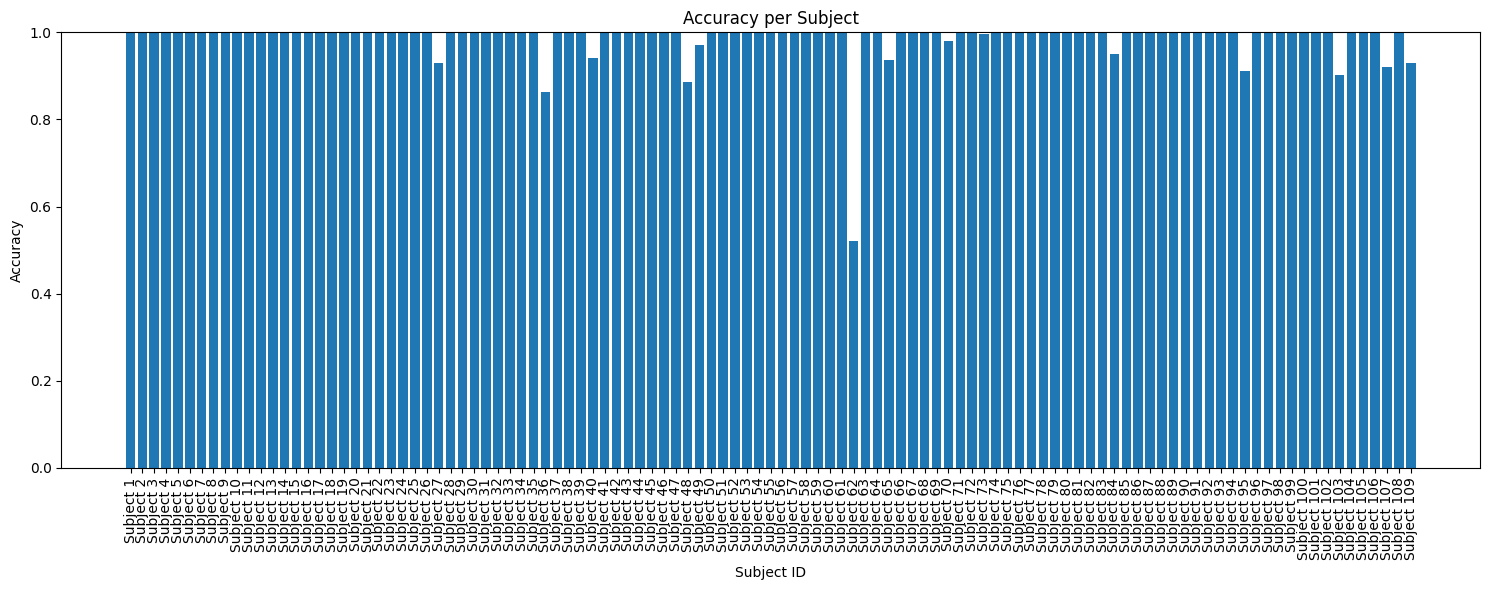

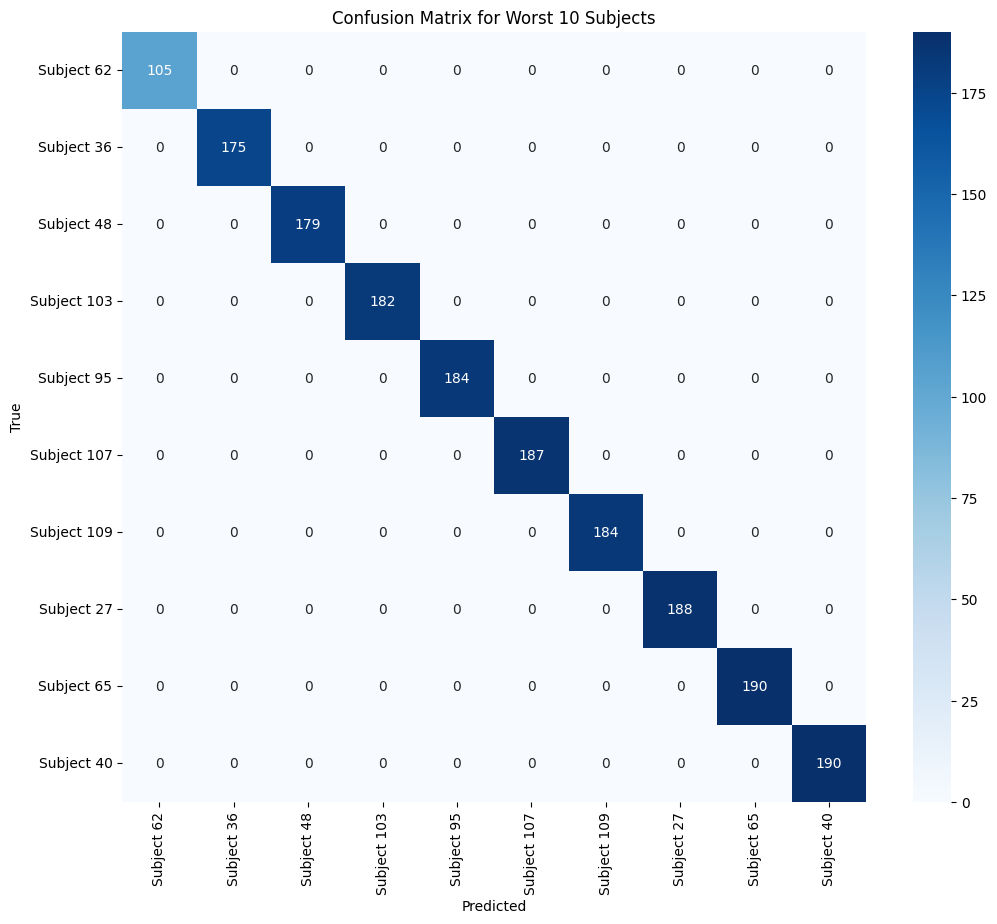

In [ ]:
print("\nPerformance on Training Data (Eyes Open):")
test_model(model, train_loader, device, subject_names)


Performance on Test Data (Eyes Closed):

Overall Accuracy: 0.2716


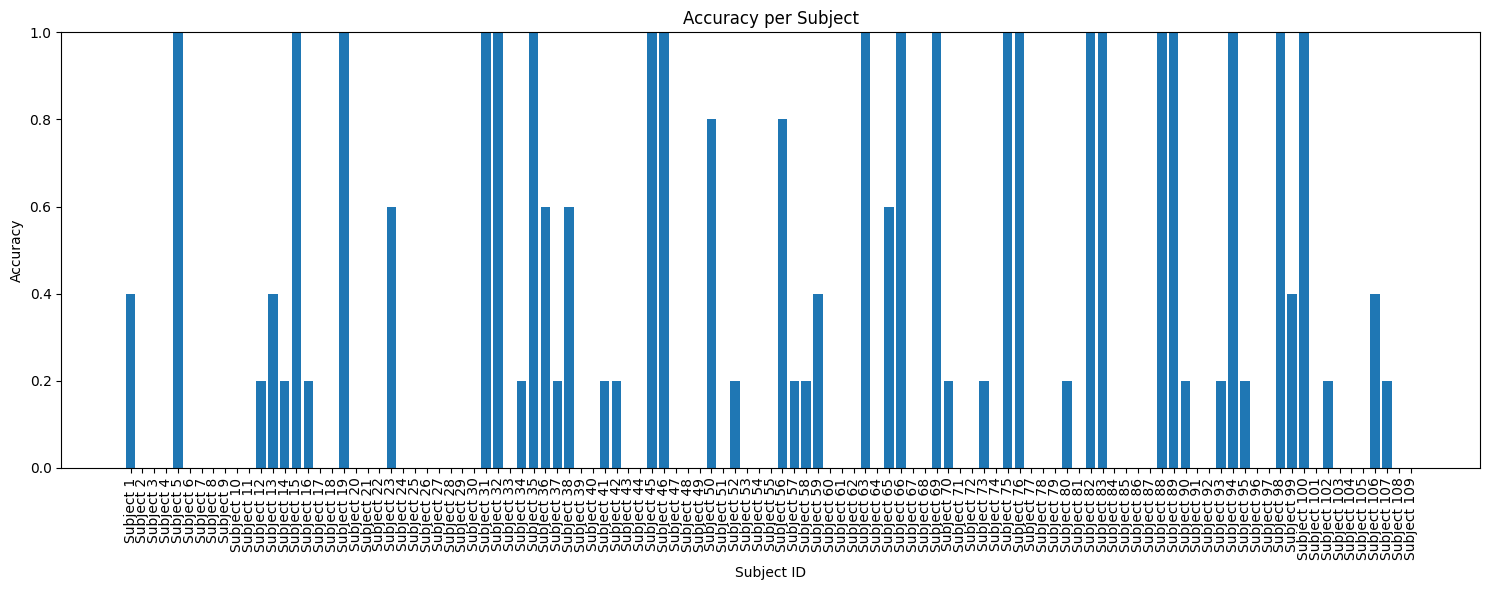

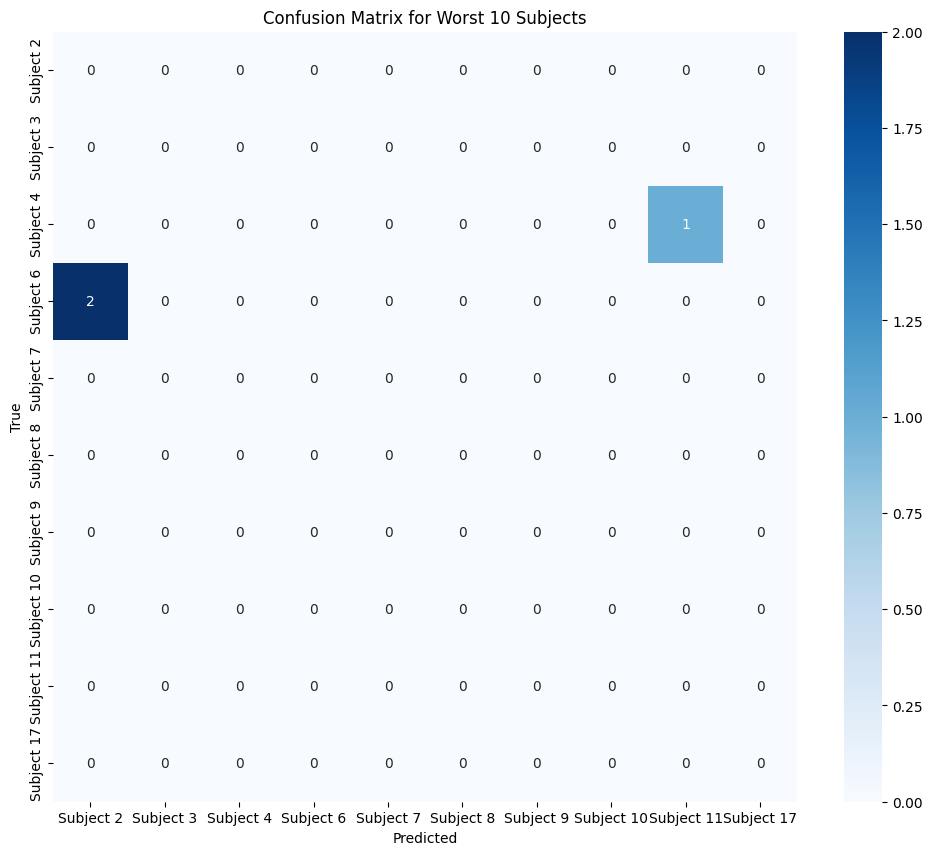

In [ ]:
print("\nPerformance on Test Data (Eyes Closed):")
test_model(model, test_loader, device, subject_names)